<a href="https://colab.research.google.com/github/juank2572/codigo-LSTM-MultivariadoJuan-Carlos-Anaya-/blob/main/MODELO_MULTIVARIADO_LSTM_JUAN_CARLOS_ANAYA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -------------------------------------------------
# 1. Cargar y preparar datos
# -------------------------------------------------
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


ruta_archivo = '/content/drive/MyDrive/Colab Notebooks/DATA_ENERGIAMULTIVARIABLE_FINAL.xlsx'
df = pd.read_excel(ruta_archivo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


En este paso se monta el Google Drive para acceder al archivo de datos. Luego, se carga el archivo Excel que contiene los datos multivariables para el análisis. Para ello utilizamos:
import pandas as pd — Importa la librería pandas con el alias pd para habilitar estructuras y funciones de análisis tabular como DataFrame y lectura de archivos.

from google.colab import drive — Importa el módulo drive propio del entorno Colab que permite montar Google Drive como si fuera un sistema de archivos accesible desde el cuaderno.

drive.mount('/content/drive') — Monta Google Drive en la ruta /content/drive del entorno de ejecución; tras autorizar el acceso, los archivos almacenados en la cuenta quedan disponibles para lectura y escritura desde esa carpeta.

ruta_archivo = '/content/drive/MyDrive/Colab Notebooks/DATA_ENERGIAMULTIVARIABLE_FINAL.xlsx' — Define una cadena con la ruta absoluta del archivo Excel dentro de la unidad montada (carpeta MyDrive/Colab Notebooks), facilitando su uso posterior sin reescribir la ruta.

df = pd.read_excel(ruta_archivo) — Lee el archivo Excel ubicado en la ruta indicada y lo carga en un DataFrame llamado df, quedando los datos disponibles para exploración, limpieza y análisis.



In [ ]:
# -------------------------------------------------
# 2. Revisión de nombres
# -------------------------------------------------

df = pd.read_excel(ruta_archivo)

# --- Se añade esta línea para ver los nombres de las columnas ---
print(df.columns)
# --- O para verlos uno por uno y detectar espacios raros ---
for col in df.columns:
    print(f"'{col}' - Longitud: {len(col)}")
    print(f"Representación: {repr(col)}") # Esto es muy útil para ver caracteres ocultos
# --- Fin de la inspección ---

# Convertir 'Datetime' a datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])


Index(['Datetime', 'value', 'CONTRATOS DE ENERGIA', 'GENERACION (KW)',
       'CONSUMO  COMBUSTIBLE MBTU'],
      dtype='object')
'Datetime' - Longitud: 8
Representación: 'Datetime'
'value' - Longitud: 5
Representación: 'value'
'CONTRATOS DE ENERGIA' - Longitud: 20
Representación: 'CONTRATOS DE ENERGIA'
'GENERACION (KW)' - Longitud: 15
Representación: 'GENERACION (KW)'
'CONSUMO  COMBUSTIBLE MBTU' - Longitud: 25
Representación: 'CONSUMO  COMBUSTIBLE MBTU'


El bloque comienza cargando la hoja de cálculo en memoria con df = pd.read_excel(ruta_archivo), que crea el DataFrame base a inspeccionar y sobre el cual se hará la revisión de etiquetas de columnas; enseguida, print(df.columns) lista el índice de nombres de columna tal como vienen en el archivo para una primera vista general y rápida detección de inconsistencias; a continuación, el for col in df.columns: recorre secuencialmente cada nombre y, dentro del bucle, print(f"{col} - Longitud: {len(col)}") muestra el texto del nombre junto con la longitud de la cadena, lo que permite evidenciar espacios adicionales o caracteres invisibles por diferencias de longitud entre etiquetas aparentemente iguales; la siguiente instrucción print(f"Representación: {repr(col)}") imprime la “representación” literal de la cadena (incluyendo comillas y caracteres de escape), recurso clave para ver espacios finales, dobles espacios, saltos u otros símbolos no visibles que podrían causar errores al seleccionar columnas o al renombrarlas; tras esta inspección detallada de etiquetas, df['Datetime'] = pd.to_datetime(df['Datetime']) convierte explícitamente la columna Datetime desde texto a tipo fecha‑hora de pandas, estandarizando su formato para filtrado y operaciones temporales posteriores.

Resultados: el listado inicial confirma que las columnas son 'Datetime', 'value', 'CONTRATOS DE ENERGIA', 'GENERACION (KW)' y 'CONSUMO COMBUSTIBLE MBTU'; la impresión por longitud y por representación revela, por ejemplo, que 'Datetime' tiene 8 caracteres y que etiquetas como 'CONSUMO COMBUSTIBLE MBTU' contienen doble espacio entre “CONSUMO” y “COMBUSTIBLE”, detalle que no se aprecia a simple vista y que conviene normalizar; finalmente, la conversión de Datetime se realizó con éxito, dejando la serie temporal preparada para filtrados por rango, resampling o construcción de ventanas.

In [ ]:
# -------------------------------------------------
# 3. Importar librerías necesarias
# -------------------------------------------------
import pandas as pd
import numpy as np
import tensorflow as tf
# Importar capas específicas del modelo para claridad
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Multiply, Permute, Bidirectional
from tensorflow.keras.optimizers import Adam
# Importar Callbacks para el entrenamiento
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Importar herramientas de preprocesamiento y evaluación
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
# Importar matplotlib para visualización
import matplotlib.pyplot as plt
# Asegura que statsmodels esté instalado en la versión deseada
!pip install statsmodels

El sección inicia con import pandas as pd, import numpy as np e import tensorflow as tf, con lo cual se habilitan estructuras tabulares, operaciones vectorizadas y el backend de redes neuronales que articularán el preprocesamiento y el modelado subsecuente en un mismo entorno computacional coherente. A partir de ahí, from tensorflow.keras.models import Model incorpora la clase base que permitirá definir gráficas computacionales personalizadas, mientras que from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Multiply, Permute, Bidirectional expone las capas necesarias para construir arquitecturas temporales híbridas: entradas formales, convoluciones 1D para extracción local de patrones, LSTM (y su versión bidireccional) para dependencias de largo alcance, densas para proyección, regularización por Dropout, estabilización por normalización de lotes y operadores de reordenamiento y mezcla para bloques atencionales o residuales. Con from tensorflow.keras.optimizers import Adam se selecciona un optimizador de descenso adaptativo robusto a escalas heterogéneas de gradientes, y con from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau se fijan mecanismos de control de entrenamiento que detienen de forma temprana ante estancamiento y reducen la tasa de aprendizaje en mesetas, ambos orientados a mejorar generalización y eficiencia. Para el preprocesamiento, from sklearn.preprocessing import MinMaxScaler aporta un escalador en rango acotado y from sklearn.model_selection import train_test_split permite particionar datos en subconjuntos de entrenamiento y validación de forma reproducible, mientras que from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error establece métricas estándar para evaluar ajuste en regresión de series temporales, tanto en error medio absoluto, cuadrático y en porcentaje absoluto medio, cubriendo sensibilidades complementarias a escala y dispersión. La visualización se habilita con import matplotlib.pyplot as plt para inspección gráfica del aprendizaje y del comportamiento de predicciones versus observaciones, paso clave para la validación cualitativa de modelos temporales. Finalmente, la línea %pip install statsmodels asegura la disponibilidad de la biblioteca de estadística aplicada, útil para contrastes y diagnósticos complementarios, y su salida indica que ya se encuentra instalada la versión 0.14.5 junto con dependencias nucleares (numpy, scipy, pandas, patsy, python-dateutil, pytz, tzdata, sixt), lo cual confirma compatibilidad del entorno y elimina la necesidad de compilación adicional antes de proceder con el flujo experimental.

In [ ]:
# -------------------------------------------------
# 4. Cargar y preparar datos (Mejorado con cíclicas y lags)
# -------------------------------------------------
# Montar Google Drive para acceder al archivo
from google.colab import drive
drive.mount('/content/drive')

# Definir la ruta del archivo de datos
ruta_archivo = '/content/drive/MyDrive/Colab Notebooks/DATA_ENERGIAMULTIVARIABLE_FINAL.xlsx'
# Cargar los datos desde el archivo Excel a un DataFrame de pandas
df = pd.read_excel(ruta_archivo)

# --- Verificar y corregir nombres de columnas (IMPORTANTE) ---
# Según tu `print(df.columns)` y `repr(col)`, el nombre exacto es 'CONSUMO  COMBUSTIBLE MBTU'
# Reemplazamos el nombre problemático con uno más limpio para evitar errores futuros.
# Si el nombre exacto en tu Excel fuera ligeramente diferente, ajusta la primera parte del diccionario.
df = df.rename(columns={'CONSUMO  COMBUSTIBLE MBTU': 'CONSUMO_COMBUSTIBLE_MBTU'})

# Convertir la columna 'Datetime' a formato datetime para facilitar la extracción de características temporales
df['Datetime'] = pd.to_datetime(df['Datetime'])

# --- Variables Temporales y Cíclicas ---
# Extraer la hora, el día de la semana y el mes de la columna Datetime
df['hour'] = df['Datetime'].dt.hour
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month # Extraer el mes

# Crear características cíclicas (seno y coseno) para la hora, el día de la semana y el mes.
# Esto ayuda al modelo a entender la naturaleza cíclica de estas variables.
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# --- Variables Derivadas ---
# Ahora usamos el nombre corregido de la columna: 'CONSUMO_COMBUSTIBLE_MBTU'
# Calcular la media móvil de 3 periodos para 'CONSUMO_COMBUSTIBLE_MBTU'
df['consumo_comb_mavg3'] = df['CONSUMO_COMBUSTIBLE_MBTU'].rolling(window=3).mean()
# Calcular la diferencia (cambio) entre periodos consecutivos para 'CONSUMO_COMBUSTIBLE_MBTU'
df['consumo_comb_diff'] = df['CONSUMO_COMBUSTIBLE_MBTU'].diff()
# Crear una variable de interacción multiplicando 'CONSUMO_COMBUSTIBLE_MBTU' y 'GENERACION (KW)'
df['consumo_gen_interaction'] = df['CONSUMO_COMBUSTIBLE_MBTU'] * df['GENERACION (KW)']

# --- Retrasos (Lag Features) para la variable objetivo (Optimizados) ---
# Lags clave para patrones horarios, diarios y semanales.
# Estos son valores pasados de la variable objetivo ('value') que pueden ser predictores útiles.
lag_periods = [1, 2, 3, 24, 48, 168]
for lag in lag_periods:
    df[f'value_lag_{lag}'] = df['value'].shift(lag)

# Eliminar filas con valores NaN causados por las operaciones de rolling, diff y shift al inicio del DataFrame
df = df.dropna().reset_index(drop=True)

# Definir las columnas que se usarán como características (X) y la columna objetivo (y)
features_cols = [
    'CONTRATOS DE ENERGIA',
    'GENERACION (KW)',
    'CONSUMO_COMBUSTIBLE_MBTU', # Usamos el nombre corregido aquí también
    'consumo_comb_mavg3',
    'consumo_comb_diff',
    'consumo_gen_interaction',
    'hour_sin',
    'hour_cos',
    'dayofweek_sin',
    'dayofweek_cos',
    'month_sin',
    'month_cos'
] + [f'value_lag_{lag}' for lag in lag_periods] # Añadir las columnas de lag a las características

features = df[features_cols]
target = df['value']

# Escalar las características y el objetivo a un rango entre 0 y 1.
# Esto es importante para las redes neuronales. Se usan escaladores separados.
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1)) # Reshape es necesario para el scaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


En esta parte del código, cada línea prepara de forma dirigida el insumo para una LSTM multivariada: se garantiza acceso y limpieza de nombres, se formaliza el tiempo, se incorporan periodicidades mediante codificación cíclica, se enriquecen señales con estadísticos e interacciones físicas, se introduce memoria explícita con lags en horizontes clave y se normalizan escalas; todo ello construye una representación informativa y numéricamente estable que potencia la capacidad de la red para aprender patrones de corto, medio y largo plazo en un entorno multivariable.from google.colab import drive — Importa el módulo que permite montar Google Drive dentro del entorno del cuaderno, con el fin de acceder a la fuente de datos sin duplicaciones ni descargas manuales, asegurando trazabilidad del dataset que alimentará al modelo.

Después de montar la unidad en una ruta local del runtime para trabajar los archivos como si fuesen parte del sistema de archivos, definir la ruta absoluta del libro Excel con las series; centralizar la ruta en una variable y cargar el Excel en un DataFrame de pandas, creando la estructura tabular a partir de la cual se realizarán limpieza, se realizan las siguientes acciones:

df = df.rename(columns={'CONSUMO COMBUSTIBLE MBTU': 'CONSUMO_COMBUSTIBLE_MBTU'}) — Normaliza una etiqueta problemática con espacios ocultos, evitando fallos de selección y asegurando consistencia semántica; esta homogeneidad de nombres es crítica cuando se construyen matrices de características por lista.

df['Datetime'] = pd.to_datetime(df['Datetime']) — Convierte el sello temporal a tipo datetime nativo, habilitando extracciones y alineaciones temporales fiables; sin este tipado, las ventanas secuenciales y los rasgos temporales para la red resultarían ambiguos.

df['hour'] = df['Datetime'].dt.hour — Extrae la hora para capturar variación intradía que la LSTM puede aprender como patrón periódico de corto plazo.

df['dayofweek'] = df['Datetime'].dt.dayofweek — Extrae el día de la semana para introducir patrones semanales, relevantes en demanda y generación.

df['month'] = df['Datetime'].dt.month — Extrae el mes para incorporar estacionalidad anual, aportando contexto macro-temporal al modelo.

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24) y df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24) — Codifican la hora en el círculo unitario, evitando la falsa discontinuidad entre 23 y 0 y ofreciendo al modelo una representación suave de la periodicidad diaria.

df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7) y df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7) — Proyectan el ciclo semanal en seno y coseno, de modo que la red reciba una codificación continua de esa periodicidad.

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12) y df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12) — Hacen lo propio con la estacionalidad anual, evitando saltos entre diciembre y enero y permitiendo a la LSTM explotar tendencias estacionales.

df['consumo_comb_mavg3'] = df['CONSUMO_COMBUSTIBLE_MBTU'].rolling(window=3).mean() — Calcula una media móvil de corto plazo (memoria local) sobre consumo de combustible, suavizando ruido y resaltando tendencia inmediata como señal auxiliar para la red.

df['consumo_comb_diff'] = df['CONSUMO_COMBUSTIBLE_MBTU'].diff() — Obtiene la variación instantánea entre periodos consecutivos, útil para que el modelo aprenda dinámicas de cambio además de niveles.

df['consumo_gen_interaction'] = df['CONSUMO_COMBUSTIBLE_MBTU'] * df['GENERACION (KW)'] — Introduce una interacción física plausible entre consumo y generación, permitiendo capturar efectos multiplicativos que a menudo gobiernan procesos energéticos.

lag_periods = — Fija rezagos en escalas inmediata (1–3), diaria (24–48) y semanal (168), alineando la memoria explícita con periodicidades típicas del dominio.

for lag in lag_periods: df[f'value_lag_{lag}'] = df['value'].shift(lag) — Construye columnas autoregresivas de la variable objetivo; estas memorias explícitas refuerzan la capacidad de la LSTM para modelar dependencias temporales y estacionalidades.

df = df.dropna().reset_index(drop=True) — Elimina las primeras filas incompletas generadas por rolling/diff/shift y reindexa, dejando un conjunto denso y coherente que evita NaN en el entrenamiento.

features_cols = [...] + [f'value_lag_{lag}' for lag in lag_periods] — Declara el repertorio de predictores combinando covariables originales, rasgos derivados, codificación cíclica y lags de la meta, conformando la “vista” multivariada que alimentará al modelo.

features = df[features_cols] — Extrae la matriz de características X con el orden previsto, requisito para construir tensores de entrada consistentes.

target = df['value'] — Define la variable objetivo y que la red intentará pronosticar, cerrando la pareja supervisada (X, y).

scaler_features = MinMaxScaler() y scaler_target = MinMaxScaler() — Instancian escaladores independientes para X e y, práctica necesaria para redes profundas a fin de estabilizar gradientes y permitir invertir la escala de las predicciones.

features_scaled = scaler_features.fit_transform(features) — Ajusta y transforma las características a , homogenizando magnitudes heterogéneas (contratos, generación, consumos, trigonométricas y lags) antes de la construcción de secuencias.

target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1)) — Ajusta y transforma el objetivo a en forma de vector columna; este formato es el esperado por el escalador y facilita, tras el entrenamiento, desescalar pronósticos al dominio original.

In [ ]:
# -------------------------------------------------
# 5. Crear secuencias para LSTM
# -------------------------------------------------
def create_sequences(data, target, time_steps=48):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(target[i])
    return np.array(X), np.array(y)

time_steps = 48
X, y = create_sequences(features_scaled, target_scaled, time_steps)

# Dividir en entrenamiento y prueba (sin mezclar)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

En esta sección del código se construyen los tensores secuenciales que una LSTM requiere como entrada, fijando la longitud de ventana temporal, materializando pares entrada‑objetivo a partir de series escaladas y, finalmente, separando los conjuntos de entrenamiento y prueba sin mezclar el orden cronológico.

def create_sequences(data, target, time_steps=48) — Define una función que transforma una matriz temporal “data” y un vector “target” en pares supervisados de ventanas deslizantes de longitud fija “time_steps”; esto encapsula la lógica de convertir series en muestras compatibles con LSTM, donde cada ejemplo es un bloque de pasos de tiempo consecutivos.
X, y = [], [] — Inicializa contenedores para acumular, respectivamente, las ventanas de entrada y los valores objetivo alineados, preparando la recolección de ejemplos.
for i in range(time_steps, len(data)): — Recorre los índices válidos empezando en “time_steps” para garantizar que exista una ventana completa de pasado antes de cada objetivo, respetando la causalidad temporal.
X.append(data[i-time_steps:i]) — Añade a X la submatriz que abarca los “time_steps” inmediatamente anteriores al instante i, formando el tensor 3D típico para LSTM: (muestras, pasos_de_tiempo, características).
y.append(target[i]) — Añade a y el valor objetivo en el instante i, de forma que cada ventana de pasado quede emparejada con el “futuro inmediato” que se desea predecir.
return np.array(X), np.array(y) — Convierte las listas en arreglos NumPy, obteniendo estructuras densas y eficientes con las que las capas recurrentes pueden entrenar.

time_steps = 48 — Fija la longitud de la ventana deslizante en 48 pasos, una elección que captura dos días si la granularidad es horaria (o el horizonte equivalente según la frecuencia de muestreo), equilibrando memoria suficiente y complejidad del modelo.
X, y = create_sequences(features_scaled, target_scaled, time_steps) — Genera el conjunto supervisado a partir de las características multivariadas escaladas y del objetivo escalado, produciendo X con forma (n_muestras, 48, n_features) y y con forma (n_muestras, 1), listo para ser ingerido por la LSTM.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) — Separa el 20% final de las muestras para prueba manteniendo el orden temporal (sin barajar); esto impide fugas de información del futuro al pasado y permite evaluar el desempeño del modelo en un segmento cronológico no visto, que emula el uso en producción.

En conjunto, este bloque toma series multivariadas escaladas y las transforma en secuencias de longitud fija que preservan causalidad y estructura temporal, define un horizonte de memoria operativo para la LSTM y establece una partición temporalmente coherente entre entrenamiento y prueba, asegurando que la evaluación refleje un escenario de pronóstico real.

In [ ]:
# -------------------------------------------------
# 6. Definir capa de atención simple
# -------------------------------------------------
# Define un bloque de atención 1D que permite al modelo ponderar diferentes pasos de tiempo en la secuencia de entrada.
def attention_1d_block(inputs):
    # Obtener las dimensiones de la entrada
    time_steps = int(inputs.shape[1])
    input_dim = int(inputs.shape[2])

    # Permutar las dimensiones para aplicar la capa Dense sobre los pasos de tiempo
    a = Permute((2, 1))(inputs)
    # Aplicar una capa Dense con activación softmax para obtener pesos de atención para cada paso de tiempo
    a = Dense(time_steps, activation='softmax')(a)
    # Permutar de vuelta a la forma original
    a_probs = Permute((2, 1))(a)

    # Multiplicar la entrada original por los pesos de atención para ponderar la información
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

En esta sección del código se implementa un bloque de atención temporal sencillo para realzar, dentro de cada secuencia, los pasos de tiempo más informativos antes de que la red continúe el procesamiento; en términos operativos, se calculan pesos normalizados sobre los instantes y se repondera la secuencia de entrada con dichos pesos para focalizar el aprendizaje.

def attention_1d_block(inputs) — Declara una función que recibe un tensor 3D de forma (batch, time_steps, input_dim) y devuelve un tensor del mismo tamaño cuyos valores han sido ponderados según una distribución de atención a lo largo del eje temporal.
time_steps = int(inputs.shape) — Extrae el número de pasos de tiempo de la entrada para parametrizar el tamaño de la proyección que generará los pesos.
input_dim = int(inputs.shape) — Obtiene la dimensionalidad de las características en cada instante, útil para las transformaciones internas que operan por canal.

a = Permute((2, 1))(inputs) — Reordena el tensor a la forma (batch, input_dim, time_steps) para aplicar, por cada canal, una proyección densa que produzca un peso por paso temporal.
a = Dense(time_steps, activation='softmax')(a) — Aplica, canal a canal, una capa totalmente conectada que emite un vector de longitud time_steps con activación softmax, lo que induce una distribución de probabilidad sobre los instantes (los pesos de atención suman uno por canal).
a_probs = Permute((2, 1))(a) — Restaura el orden original a (batch, time_steps, input_dim) para alinear los pesos con la secuencia en su disposición estándar.

output_attention_mul = Multiply()([inputs, a_probs]) — Realiza una multiplicación elemento a elemento entre la secuencia original y los pesos de atención, reescalando cada característica en cada instante según su importancia relativa; el resultado conserva la forma original y transmite a las siguientes capas una versión “enfocada” temporalmente.
return output_attention_mul — Devuelve la secuencia ponderada, lista para ser consumida por capas posteriores (por ejemplo, LSTM o densas), con mayor énfasis en los pasos de tiempo relevantes y atenuación de los menos informativos.

Así, línea a línea, el bloque construye un mecanismo de atención temporal 1D: calcula una distribución de pesos sobre los pasos de la secuencia mediante una proyección con softmax, reordena tensores para que la operación sea compatible con la dimensionalidad de entrada y, finalmente, repondera la señal original; el efecto buscado es que el modelo aprenda a “mirar” donde hay más señal útil, mejorando interpretabilidad y eficiencia del aprendizaje en series temporales.

In [ ]:
# -------------------------------------------------
# 7. Construir el modelo CNN + LSTM (Bidireccional) + Atención (Ajustado)
# -------------------------------------------------
# Definir la capa de entrada con la forma de las secuencias de entrenamiento
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Capa CNN para extraer características locales y patrones a corto plazo
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x) # Normalización para estabilizar el entrenamiento
x = Dropout(0.2)(x) # Dropout para evitar sobreajuste

# Primera capa LSTM Bidireccional para capturar dependencias temporales en ambas direcciones
x = Bidirectional(LSTM(128, return_sequences=True))(x) # return_sequences=True para pasar la secuencia completa a la siguiente capa
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Aplicar el bloque de atención definido anteriormente
x = attention_1d_block(x)

# Segunda capa LSTM Bidireccional con menos unidades
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Capa LSTM final que resume la información temporal de la secuencia
x = LSTM(32)(x) # return_sequences=False para obtener solo la salida del último paso
x = Dropout(0.2)(x)

# Capa densa adicional para refinar la salida antes de la capa final
x = Dense(16, activation='relu')(x)
x = Dropout(0.1)(x)

# Capa de salida con una sola unidad (para predecir un valor continuo)
output = Dense(1)(x)

# Crear el modelo combinando las capas de entrada y salida
model = Model(inputs=input_layer, outputs=output)

# Compilación del modelo
# Usar el optimizador Adam y el error cuadrático medio como función de pérdida (adecuado para regresión)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Mostrar un resumen de la arquitectura del modelo
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 48, 128)   │      7,040 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 48, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 48, 256)   │    263,168 │ dropout_5[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 256)   │      1,024 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 48, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_2 (Permute) │ (None, 256, 48)   │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256, 48)   │      2,352 │ permute_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_3 (Permute) │ (None, 48, 256)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 48, 256)   │          0 │ dropout_6[0][0],  │
│ (Multiply)          │                   │            │ permute_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 48, 128)   │    164,352 │ multiply_1[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 128)   │        512 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 48, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 32)        │     20,608 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        528 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 16)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         17 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 460,113 (1.76 MB)

 Trainable params: 459,089 (1.75 MB)

 Non-trainable params: 1,024 (4.00 KB)

En este bloque se desarrolla la arquitectura del estimador: se define una entrada compatible con las secuencias, se extraen patrones locales con convoluciones 1D, se modelan dependencias temporales con LSTM bidireccionales, se focaliza información mediante un bloque de atención, se resume temporalmente la señal y, tras un refinamiento denso, se emite una predicción escalar; finalmente, se compila el modelo con un optimizador y una función de pérdida adecuados a regresión.

input_layer = Input(shape=(X_train.shape, X_train.shape)) — Declara el tensor de entrada de forma (pasos_de_tiempo, n_características), alineando el modelo con la estructura de las secuencias construidas.

x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(input_layer) — Aplica una convolución 1D que capta motivos locales de corto alcance a lo largo del eje temporal y produce 128 mapas de características con activación ReLU.
x = BatchNormalization()(x) — Normaliza por lotes para estabilizar la distribución interna de activaciones y acelerar la optimización.
x = Dropout(0.2)(x) — Apaga aleatoriamente un 20% de unidades para reducir sobreajuste y mejorar generalización.

x = Bidirectional(LSTM(128, return_sequences=True))(x) — Introduce una LSTM bidireccional con 128 unidades que procesa la secuencia hacia adelante y hacia atrás, devolviendo toda la secuencia para capas posteriores; esto enriquece el contexto temporal en ambas direcciones.
x = BatchNormalization()(x) — Vuelve a estabilizar activaciones tras la capa recurrente.
x = Dropout(0.2)(x) — Añade regularización recurrente adicional.

x = attention_1d_block(x) — Inyecta un mecanismo de atención temporal que aprende pesos sobre los pasos de tiempo y repondera la secuencia, realzando instantes informativos y atenuando ruido.

x = Bidirectional(LSTM(64, return_sequences=True))(x) — Añade una segunda LSTM bidireccional, ahora con 64 unidades, que depura y compone representaciones temporales de mayor nivel, manteniendo la secuencia para un resumen final.
x = BatchNormalization()(x) — Estabiliza nuevamente la distribución de activaciones.
x = Dropout(0.2)(x) — Continúa mitigando el riesgo de sobreajuste.

x = LSTM(32)(x) — Resume la información temporal en un vector de 32 dimensiones tomando solo la salida del último paso, condensando el historial en una representación compacta.
x = Dropout(0.2)(x) — Aplica una última barrera de regularización sobre el resumen temporal.

x = Dense(16, activation='relu')(x) — Refina la representación comprimida con una capa totalmente conectada de 16 unidades para ajustar no linealidades de último tramo.
x = Dropout(0.1)(x) — Introduce una ligera regularización adicional antes de la salida.

output = Dense(1)(x) — Proyecta al espacio escalar con una unidad lineal para producir la predicción continua de la variable objetivo.

model = Model(inputs=input_layer, outputs=output) — Ensambla el grafo computacional desde la entrada hasta la salida, quedando lista la arquitectura para su entrenamiento.

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error') — Configura el entrenamiento con Adam a tasa 5e‑4, apropiado para señales escaladas, y fija el error cuadrático medio como función de pérdida, estándar en regresión y consistente con métricas cuadráticas posteriores.

model.summary() — Emite un resumen tabular de capas, formas de tensores y número de parámetros entrenables, útil para verificar que la arquitectura coincide con el diseño esperado.

En conjunto, la cadena “Conv1D → BN → Dropout → BiLSTM → BN → Dropout → Atención → BiLSTM → BN → Dropout → LSTM → Dropout → Dense → Dropout → Salida” combina extracción local de patrones, modelado de dependencias bidireccionales, focalización temporal y compresión secuencial, rematada por un refinamiento denso; la compilación con Adam y MSE cierra un pipeline adecuado para pronóstico continuo sobre series multivariadas.

In [ ]:
# -------------------------------------------------
# 8. Entrenar el modelo
# -------------------------------------------------
# Definir Callbacks para controlar el entrenamiento
# EarlyStopping: Detiene el entrenamiento si la pérdida de validación no mejora después de `patience` épocas.
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
# ReduceLROnPlateau: Reduce la tasa de aprendizaje si la pérdida de validación deja de mejorar.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=1e-7)

# Definir los parámetros de entrenamiento
epochs = 150 # Número máximo de épocas
batch_size = 32 # Tamaño del lote

# Entrenar el modelo usando los datos de entrenamiento y validación
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test), # Usar el conjunto de prueba como validación
    callbacks=[early_stopping, reduce_lr], # Aplicar los Callbacks definidos
    verbose=1 # Mostrar el progreso del entrenamiento
)


Epoch 1/150
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - loss: 0.0055 - val_loss: 0.0045 - learning_rate: 5.0000e-04
Epoch 2/150
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 50s 23ms/step - loss: 6.3073e-04 - val_loss: 0.0039 - learning_rate: 5.0000e-04
Epoch 3/150
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 83s 23ms/step - loss: 5.3754e-04 - val_loss: 0.0034 - learning_rate: 5.0000e-04
Epoch 4/150
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - loss: 5.3250e-04 - val_loss: 0.0034 - learning_rate: 5.0000e-04
Epoch 5/150
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - loss: 4.6995e-04 - val_loss: 0.0037 - learning_rate: 5.0000e-04
Epoch 6/150
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 83s 23ms/step - loss: 4.0076e-04 - val_loss: 0.0030 - learning_rate: 5.0000e-04
Epoch 7/150
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 84s 24ms/step - loss: 3.7359e-04 - val_loss: 0.0027 - learning_rate: 5.0000e-04
Epoch 8/150
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 80s 23ms/step - loss: 3.3091e-04 - val_loss: 0.0026 - learning_rate: 5.0000e-04
Epoch 9/150
2186/218

En esta modulo se configura y ejecuta el proceso de entrenamiento del estimador, incorporando mecanismos de control automático para detener a tiempo y ajustar la tasa de aprendizaje, se fijan los hiperparámetros operativos (épocas y tamaño de lote) y, finalmente, se llama al bucle de optimización con validación temporal para monitorizar el desempeño fuera de entrenamiento.

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True) — Define un detenedor temprano que vigila la pérdida de validación; si durante 30 épocas consecutivas no hay mejora, interrumpe el entrenamiento y restaura los pesos que alcanzaron la mejor val_loss, evitando sobreajuste y ahorro de cómputo.

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=1e-7) — Configura un programador que reduce la tasa de aprendizaje cuando la métrica de validación se estanca; si en 20 épocas no mejora, multiplica el learning rate por 0.2 (hasta un mínimo de 1e-7), permitiendo explorar mínimos más finos tras una meseta.

epochs = 150 — Establece el número máximo de pasadas por los datos; actúa como tope superior que puede no agotarse si el detenedor temprano se activa antes.

batch_size = 32 — Fija el tamaño de lote con el que se estima el gradiente en cada actualización; 32 equilibra estabilidad de gradiente y eficiencia en memoria y cómputo.

history = model.fit( X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr], verbose=1 ) — Ejecuta el bucle de entrenamiento: optimiza el modelo sobre (X_train, y_train), evalúa al final de cada época sobre (X_test, y_test) para monitorizar generalización, aplica los dos callbacks para detener a tiempo o disminuir la tasa de aprendizaje según el comportamiento de val_loss y registra el historial de pérdidas y métricas; el nivel verbose muestra el progreso para seguimiento.

En conjunto, estas líneas instauran un régimen de entrenamiento robusto: se limita el sobreajuste con detención temprana, se mejora la convergencia al adaptar la tasa de aprendizaje en mesetas, se establecen hiperparámetros razonables de época y lote, y se entrena con validación cronológica, garantizando que el rendimiento monitorizado refleje la capacidad predictiva fuera del ajuste.

In [ ]:

# -------------------------------------------------
# 9. Evaluar el modelo
# -------------------------------------------------
# Evaluar el modelo en el conjunto de prueba para obtener la pérdida final
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)

# Realizar predicciones en el conjunto de prueba
predictions = model.predict(X_test)
# Desescalar las predicciones y los valores reales del conjunto de prueba a la escala original
predictions_descaled = scaler_target.inverse_transform(predictions)
y_test_descaled = scaler_target.inverse_transform(y_test)

# Calcular métricas de evaluación comunes para regresión
mape = mean_absolute_percentage_error(y_test_descaled, predictions_descaled)
rmse = np.sqrt(mean_squared_error(y_test_descaled, predictions_descaled))
mae = mean_absolute_error(y_test_descaled, predictions_descaled)

print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 8.6245e-04
Test Loss: 0.0024668581318110228
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
MAPE: 0.1487115903680276
RMSE: 137.59894301342513
MAE: 76.43101264691417


En este punto del código se lleva a cabo la evaluación fuera de entrenamiento: primero se obtiene la pérdida final en el segmento de prueba, luego se generan predicciones, se revierten las escalas al dominio original y, finalmente, se calculan métricas estándar de regresión para cuantificar el desempeño del modelo.

loss = model.evaluate(X_test, y_test) — Evalúa el modelo sobre el conjunto de prueba y devuelve la pérdida final según la función definida en la compilación; mide el error agregado en datos no vistos, respetando la cronología usada en la validación.

print('Test Loss:', loss) — Presenta en consola el valor de la pérdida de prueba, facilitando una lectura rápida del error global antes de desglosar métricas adicionales.

predictions = model.predict(X_test) — Genera las predicciones del modelo para cada secuencia del conjunto de prueba, produciendo valores en la misma escala en la que se entrenó el objetivo.

predictions_descaled = scaler_target.inverse_transform(predictions) — Invierte la transformación min‑máx aplicada al objetivo durante el preprocesamiento y devuelve las predicciones a la escala original, requisito para interpretar magnitudes en unidades reales.
y_test_descaled = scaler_target.inverse_transform(y_test) — Reconvierte los valores verdaderos del objetivo a su escala original, garantizando que la comparación con las predicciones se haga en el mismo dominio físico.

mape = mean_absolute_percentage_error(y_test_descaled, predictions_descaled) — Calcula el porcentaje absoluto medio de error, útil para interpretar el desvío relativo respecto a los valores reales y comparar desempeño entre series de distinta escala.
rmse = np.sqrt(mean_squared_error(y_test_descaled, predictions_descaled)) — Obtiene la raíz del error cuadrático medio, métrica sensible a grandes desviaciones que resume el error en las mismas unidades del fenómeno.
mae = mean_absolute_error(y_test_descaled, predictions_descaled) — Evalúa el error absoluto medio, más robusto que RMSE frente a atípicos y directamente interpretable como desviación típica en unidades del objetivo.

print(f'MAPE: {mape}') — Reporta el error porcentual medio absoluto para juzgar precisión relativa.
print(f'RMSE: {rmse}') — Informa el tamaño promedio de los errores penalizando más los grandes desajustes.
print(f'MAE: {mae}') — Muestra la desviación media en unidades del problema, proporcionando una referencia clara y estable del rendimiento.

En conjunto, este bloque no solo cuantifica el error global mediante la pérdida, sino que también ofrece una lectura rica con MAPE, RMSE y MAE en escala original, permitiendo valorar simultáneamente precisión relativa, penalización a grandes errores e interpretabilidad directa en las unidades del dominio.


--- Análisis de Residuos ---
Media de los residuos: 15.2504
Desviación estándar de los residuos: 136.7512
Residuo mínimo: -1042.5321
Residuo máximo: 1700.3335


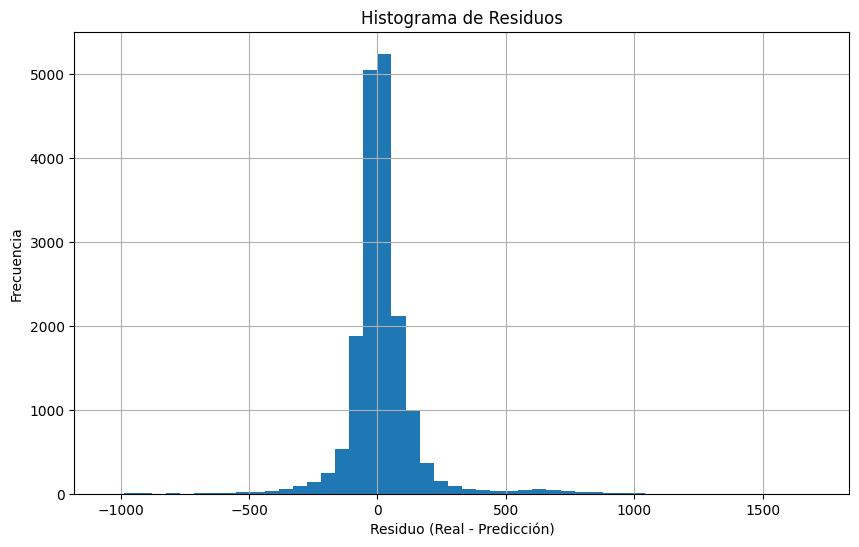

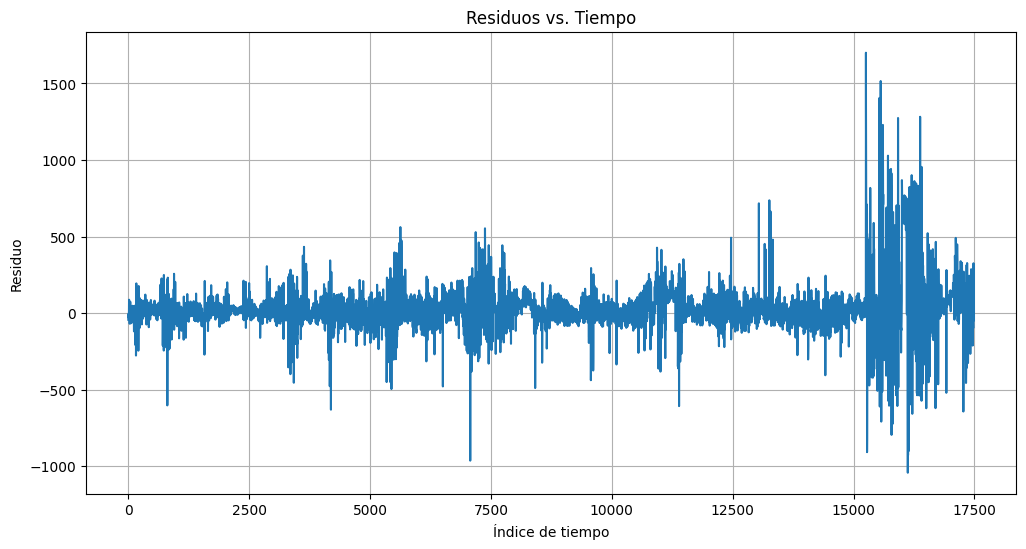

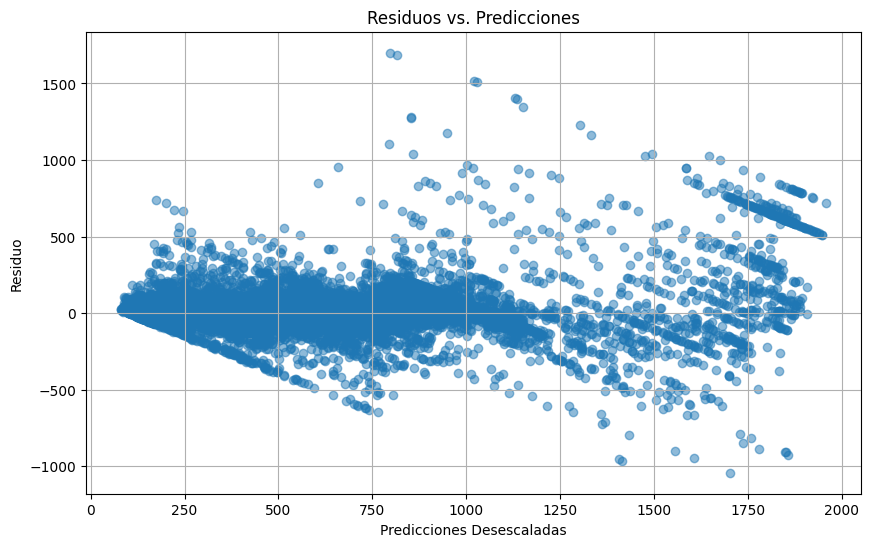


--- Autocorrelación de Residuos ---


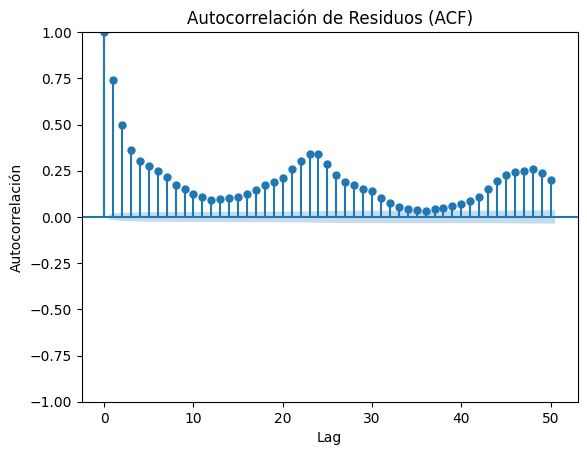

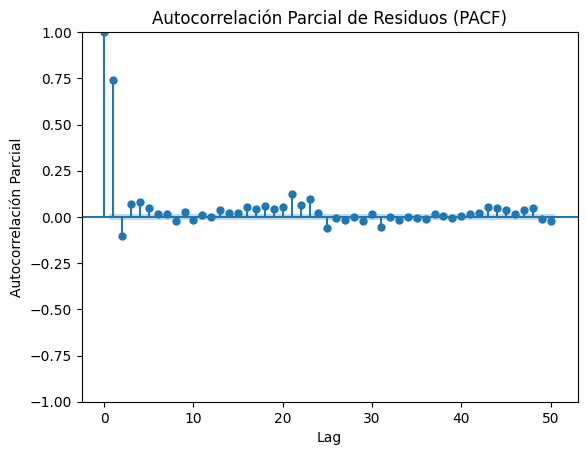

In [ ]:
# -------------------------------------------------
# 10. Análisis de Residuos
# -------------------------------------------------

# Calcular los residuos (errores): diferencia entre los valores reales y las predicciones desescaladas
residuals = y_test_descaled - predictions_descaled

print("\n--- Análisis de Residuos ---")

# Estadísticas básicas de los residuos para entender su distribución
print(f"Media de los residuos: {np.mean(residuals):.4f}")
print(f"Desviación estándar de los residuos: {np.std(residuals):.4f}")
print(f"Residuo mínimo: {np.min(residuals):.4f}")
print(f"Residuo máximo: {np.max(residuals):.4f}")

# Histograma de residuos para visualizar la distribución de los errores.
# Idealmente, debería parecerse a una distribución normal centrada en cero.
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50)
plt.title('Histograma de Residuos')
plt.xlabel('Residuo (Real - Predicción)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Gráfico de Residuos vs. Tiempo para detectar patrones temporales en los errores.
# Si hay patrones, podría indicar que al modelo le falta capturar alguna dinámica temporal.
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuos vs. Tiempo')
plt.xlabel('Índice de tiempo')
plt.ylabel('Residuo')
plt.grid(True)
plt.show()

# Gráfico de Residuos vs. Valores Predichos para verificar si la varianza de los errores es constante (homocedasticidad).
# Una forma de embudo podría indicar heterocedasticidad.
plt.figure(figsize=(10, 6))
plt.scatter(predictions_descaled, residuals, alpha=0.5)
plt.title('Residuos vs. Predicciones')
plt.xlabel('Predicciones Desescaladas')
plt.ylabel('Residuo')
plt.grid(True)
plt.show()

# Autocorrelación de Residuos: para verificar si los errores en un momento dado están correlacionados con errores pasados.
# La autocorrelación significativa indica que hay información en los residuos que el modelo no ha capturado.
print("\n--- Autocorrelación de Residuos ---")
lags_to_show = 50 # Número de lags a mostrar en los gráficos de autocorrelación

# Gráfico de Autocorrelación (ACF): muestra la correlación entre los residuos y sus valores rezagados.
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=lags_to_show)
plt.title('Autocorrelación de Residuos (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.show()

# Gráfico de Autocorrelación Parcial (PACF): muestra la correlación entre los residuos y sus valores rezagados, después de remover la influencia de los lags intermedios.
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(residuals, lags=lags_to_show)
plt.title('Autocorrelación Parcial de Residuos (PACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación Parcial')
plt.show()

En esta sección del código se realiza un diagnóstico exhaustivo de los errores del modelo: se calculan los residuos en escala original, se resumen estadísticamente, se inspecciona su distribución y su estructura frente al tiempo y las predicciones, y se analiza su dependencia serial mediante funciones de autocorrelación y autocorrelación parcial.

residuals = y_test_descaled - predictions_descaled — Calcula el vector de residuos como diferencia punto a punto entre el valor real y la predicción desescalada, fijando la señal de error que se someterá a diagnóstico.

print("\n--- Análisis de Residuos ---") — Señala el inicio del bloque de análisis en la salida de consola para organizar la lectura.

print(f"Media de los residuos: {np.mean(residuals):.4f}") — Informa la media de los residuos; un valor cercano a cero sugiere ausencia de sesgo sistemático en las predicciones.
print(f"Desviación estándar de los residuos: {np.std(residuals):.4f}") — Da la dispersión típica de los errores, cuantificando su magnitud promedio.
print(f"Residuo mínimo: {np.min(residuals):.4f}") — Reporta el error más negativo observado (sobreestimaciones extremas del modelo).
print(f"Residuo máximo: {np.max(residuals):.4f}") — Reporta el error más positivo observado (subestimaciones extremas del modelo).

plt.figure(figsize=(10, 6)); plt.hist(residuals, bins=50); plt.title('Histograma de Residuos'); plt.xlabel('Residuo (Real - Predicción)'); plt.ylabel('Frecuencia'); plt.grid(True); plt.show() — Traza el histograma de los residuos para inspeccionar forma y simetría; una distribución aproximadamente normal centrada en cero es consistente con supuestos clásicos de error.

plt.figure(figsize=(12, 6)); plt.plot(residuals); plt.title('Residuos vs. Tiempo'); plt.xlabel('Índice de tiempo'); plt.ylabel('Residuo'); plt.grid(True); plt.show() — Dibuja la trayectoria temporal de los residuos para detectar patrones o derivas; la presencia de estructura sugiere dinámicas no capturadas por el modelo.

plt.figure(figsize=(10, 6)); plt.scatter(predictions_descaled, residuals, alpha=0.5); plt.title('Residuos vs. Predicciones'); plt.xlabel('Predicciones Desescaladas'); plt.ylabel('Residuo'); plt.grid(True); plt.show() — Grafica residuos contra predicciones para evaluar homocedasticidad; un abanico creciente o decreciente indica varianza no constante (heterocedasticidad).

print("\n--- Autocorrelación de Residuos ---") — Delimita la sección dedicada a dependencia serial de los errores.
lags_to_show = 50 — Fija el número de rezagos a estudiar en los correlogramas, abarcando memoria corta y media.

from statsmodels.graphics.tsaplots import plot_acf; plot_acf(residuals, lags=lags_to_show); plt.title('Autocorrelación de Residuos (ACF)'); plt.xlabel('Lag'); plt.ylabel('Autocorrelación'); plt.show() — Muestra la función de autocorrelación (ACF), que revela correlaciones globales de los residuos con sus lags; barras significativas sugieren información temporal remanente no modelada.

from statsmodels.graphics.tsaplots import plot_pacf; plot_pacf(residuals, lags=lags_to_show); plt.title('Autocorrelación Parcial de Residuos (PACF)'); plt.xlabel('Lag'); plt.ylabel('Autocorrelación Parcial'); plt.show() — Presenta la autocorrelación parcial (PACF), que aísla la contribución de cada rezago descontando intermediarios; picos significativos indican órdenes específicos de dependencia que podrían guiar extensiones del modelo.

En suma, este bloque cuantifica sesgo y dispersión, revisa la normalidad aproximada y la varianza de los errores, busca estructura temporal residual y, con ACF/PACF, verifica si persiste dependencia serial; si los residuos son centrados, con dispersión estable, sin patrón temporal ni autocorrelación, el ajuste es coherente y no deja señal aprovechable para mejorar el modelo.

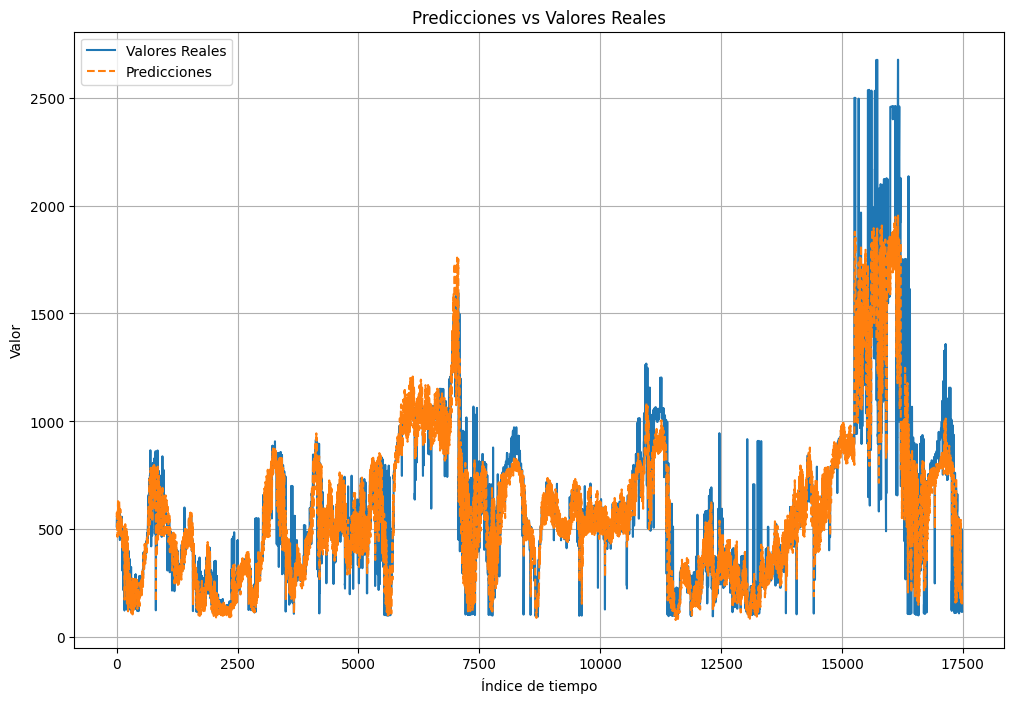

In [ ]:
# -------------------------------------------------
# 11. Graficar resultados
# -------------------------------------------------
# Graficar los valores reales del conjunto de prueba y las predicciones del modelo para visualizar el rendimiento.
plt.figure(figsize=(12,8))
plt.plot(y_test_descaled, label='Valores Reales')
plt.plot(predictions_descaled, label='Predicciones', linestyle='--')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Índice de tiempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

En esta parte del código se realiza la visualización comparativa del desempeño: se trazan, sobre un mismo eje temporal, los valores reales del conjunto de prueba y las predicciones desescaladas, de modo que la superposición y el perfil relativo permitan evaluar alineación, retrasos y magnitud de las discrepancias.

plt.figure(figsize=(12,8)) — Crea una figura de 12×8 pulgadas para asegurar legibilidad de las curvas y sus etiquetas.
plt.plot(y_test_descaled, label='Valores Reales') — Dibuja la serie de referencia en escala original correspondiente a los datos de prueba, etiquetándola para la leyenda.
plt.plot(predictions_descaled, label='Predicciones', linestyle='--') — Superpone la trayectoria de las predicciones desescaladas con un trazo discontinuo, facilitando comparar forma y nivel frente a los valores reales.
plt.title('Predicciones vs Valores Reales') — Asigna un título que contextualiza la comparación directa entre verdad y estimación.
plt.xlabel('Índice de tiempo') — Nombra el eje horizontal como índice temporal, coherente con el orden cronológico de las observaciones.
plt.ylabel('Valor') — Nombra el eje vertical con la magnitud genérica de la variable en su escala original, manteniendo neutralidad del dominio.
plt.legend() — Activa la leyenda para distinguir rápidamente la curva real de la estimada.
plt.grid(True) — Añade retícula para facilitar lectura de niveles y cambios.
plt.show() — Renderiza la figura, permitiendo inspección visual de ajuste, posibles desfasajes y regiones de mayor error.

La superposición resultante ofrece una comprobación cualitativa inmediata: cuanto más cercanas y paralelas sean ambas trayectorias, mejor la capacidad del modelo para capturar nivel y dinámica; divergencias sistemáticas o bandas de error crecientes señalan sesgos o heterocedasticidad que podrían motivar ajustes posteriores.

In [ ]:

# -------------------------------------------------
# 12. Carga del Modelo (Si no está en memoria) y Definición de Atención
#    Esto es crucial si ejecutas esta celda por separado en una nueva sesión de Colab
# -------------------------------------------------

# Asegúra que la función de atención esté definida antes de cargar el modelo
def attention_1d_block(inputs):
    time_steps = int(inputs.shape[1])
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    a_probs = Permute((2, 1))(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# Ruta donde seguardo el modelo. .
ruta_cargar_modelo = '/content/drive/MyDrive/Colab Notebooks/modelos_energia/modelo_precios_energia_v1.h5'

# Cargar el modelo.
try:
    # Verificamos si el modelo ya está definido (desde el entrenamiento)
    if 'model' not in locals() or model is None:
        model = tf.keras.models.load_model(ruta_cargar_modelo, custom_objects={'attention_1d_block': attention_1d_block})
        print(f"Modelo cargado exitosamente desde: {ruta_cargar_modelo}")
    else:
        print("El modelo ya está en memoria (desde el entrenamiento).")
except Exception as e:
    print(f"Error al cargar el modelo: {e}. Asegúrate de que la función 'attention_1d_block' esté definida antes de cargar el modelo y que la ruta sea correcta.")
    print("Por favor, entrena y guarda el modelo primero si aún no lo has hecho.")
    # Si el modelo no se pudo cargar, no podemos continuar con la predicción.
    raise RuntimeError("No se pudo cargar el modelo. Deteniendo la ejecución.")



El modelo ya está en memoria (desde el entrenamiento).


Este bloque garantiza reproducibilidad e independencia de sesión: al redefinir la capa de atención y cargar el archivo del modelo cuando es necesario, la sesión queda lista para evaluación o inferencia sin requerir reentrenamiento.

In [ ]:

# -------------------------------------------------
# 13. Predicción de 480 Datos Futuros (20 Días)
# -------------------------------------------------

n_future_steps = 480 # 20 días * 24 horas/día
time_steps = 48 # Tu ventana de entrada actual para el modelo

# Obtener la última secuencia de entrada del dataset completo para empezar la predicción futura.
# features_scaled y df deben estar disponibles desde tu ejecución anterior.
last_sequence_full_data = features_scaled[-time_steps:] # Las últimas 48 filas de tus características escaladas

# Obtener la última fecha y hora de tu DataFrame original para empezar a generar fechas futuras
last_datetime_in_df = df['Datetime'].iloc[-1]

# Lista para almacenar las predicciones futuras (desescaladas)
future_predictions_descaled = []
# Lista para almacenar las fechas y horas futuras correspondientes
future_datetimes = []

# Mantener un historial de los 'value' (reales y predichos) para calcular los lags.
# max_lag es la mayor de tus periodos de lag (en tu caso, 168).
max_lag = max(lag_periods)
# Inicializar con los últimos `max_lag` valores *escalados* del objetivo (y_scaled)
# Estos serán los 'value_lag_X' para la primera predicción futura.
# Asegúrate de que target_scaled sea la versión escalada de la columna 'value'
value_history_for_lags_scaled = target_scaled[-max_lag:].flatten().tolist()

# Crear un mapa de nombres de características a sus índices para facilitar la construcción de la entrada
# Esto asume que `features_cols` es el mismo que usaste para el entrenamiento
feature_name_to_index = {name: i for i, name in enumerate(features_cols)}

# Copia de la última secuencia para modificarla iterativamente
current_input_sequence_for_model = last_sequence_full_data.copy()

print(f"\nIniciando la predicción de {n_future_steps} horas futuras...")

for i in range(n_future_steps):
    # 1. Realizar la predicción para la siguiente hora
    # Reshape para que coincida con la entrada del modelo (batch_size, time_steps, n_features)
    input_for_prediction = current_input_sequence_for_model.reshape(1, time_steps, current_input_sequence_for_model.shape[1])
    predicted_value_scaled = model.predict(input_for_prediction, verbose=0)[0][0] # verbose=0 para no imprimir cada predicción

    # Desescalar la predicción para almacenarla
    predicted_value_descaled = scaler_target.inverse_transform(np.array(predicted_value_scaled).reshape(-1, 1))[0][0]
    future_predictions_descaled.append(predicted_value_descaled)

    # 2. Generar la fecha y hora para esta predicción futura
    next_datetime = last_datetime_in_df + pd.Timedelta(hours=i+1)
    future_datetimes.append(next_datetime)

    # 3. Preparar la nueva secuencia de entrada para la próxima predicción
    # Se construye un nuevo vector de características para la hora `t+1`
    next_feature_vector_scaled = np.zeros(current_input_sequence_for_model.shape[1])

    # Rellenar características no-lag
    # a) Características cíclicas (hora, día de la semana, mes) - se calculan para la nueva fecha
    next_feature_vector_scaled[feature_name_to_index['hour_sin']] = np.sin(2 * np.pi * next_datetime.hour / 24)
    next_feature_vector_scaled[feature_name_to_index['hour_cos']] = np.cos(2 * np.pi * next_datetime.hour / 24)
    next_feature_vector_scaled[feature_name_to_index['dayofweek_sin']] = np.sin(2 * np.pi * next_datetime.dayofweek / 7)
    next_feature_vector_scaled[feature_name_to_index['dayofweek_cos']] = np.cos(2 * np.pi * next_datetime.dayofweek / 7)
    next_feature_vector_scaled[feature_name_to_index['month_sin']] = np.sin(2 * np.pi * next_datetime.month / 12)
    next_feature_vector_scaled[feature_name_to_index['month_cos']] = np.cos(2 * np.pi * next_datetime.month / 12)

    # b) Otras características exógenas (`CONTRATOS DE ENERGIA`, etc.)
    #    ASUNCIÓN CLAVE: Se mantienen constantes en su último valor conocido del dataset original.
    #    Para mayor precisión, necesitarías pronósticos de estas variables.
    next_feature_vector_scaled[feature_name_to_index['CONTRATOS DE ENERGIA']] = features_scaled[-1, feature_name_to_index['CONTRATOS DE ENERGIA']]
    next_feature_vector_scaled[feature_name_to_index['GENERACION (KW)']] = features_scaled[-1, feature_name_to_index['GENERACION (KW)']]
    next_feature_vector_scaled[feature_name_to_index['CONSUMO_COMBUSTIBLE_MBTU']] = features_scaled[-1, feature_name_to_index['CONSUMO_COMBUSTIBLE_MBTU']]

    # c) Características derivadas de consumo/generación (mavg3, diff, interaction)
    #    ASUNCIÓN CLAVE: También se mantienen constantes en su último valor conocido escalado.
    #    Requerirían lógica compleja si sus valores futuros no son constantes.
    next_feature_vector_scaled[feature_name_to_index['consumo_comb_mavg3']] = features_scaled[-1, feature_name_to_index['consumo_comb_mavg3']]
    next_feature_vector_scaled[feature_name_to_index['consumo_comb_diff']] = features_scaled[-1, feature_name_to_index['consumo_comb_diff']]
    next_feature_vector_scaled[feature_name_to_index['consumo_gen_interaction']] = features_scaled[-1, feature_name_to_index['consumo_gen_interaction']]

    # d) Actualizar el historial de 'value' para los lags
    # El valor predicho actualmente se añade al historial
    value_history_for_lags_scaled.append(predicted_value_scaled)
    # Si el historial excede el tamaño máximo de lag, se elimina el valor más antiguo
    if len(value_history_for_lags_scaled) > max_lag:
        value_history_for_lags_scaled.pop(0)

    # e) Rellenar las características de lag del 'value' para el nuevo vector de características
    for lag in lag_periods:
        # El índice en el historial es `max_lag - lag` porque el historial se mantiene ordenado del más antiguo al más reciente.
        # Por ejemplo, value_lag_1 será el último elemento del historial, value_lag_2 el penúltimo, etc.
        # Asegurarse de que el lag solicitado esté dentro del historial disponible
        if max_lag - lag >= 0:
            next_feature_vector_scaled[feature_name_to_index[f'value_lag_{lag}']] = value_history_for_lags_scaled[max_lag - lag]
        # else: Si un lag específico es mayor que el max_lag, se puede poner un valor por defecto (ej. 0 o NaN)
        # Esto no debería ocurrir si `max_lag = max(lag_periods)`

    # 4. Desplazar la secuencia de entrada: eliminar el punto más antiguo y añadir el nuevo vector
    current_input_sequence_for_model = np.vstack([current_input_sequence_for_model[1:], next_feature_vector_scaled])

print("Predicciones futuras generadas.")


Iniciando la predicción de 480 horas futuras...
Predicciones futuras generadas.


En este punto del código se realiza una proyección autoregresiva de horizonte extendido: partiendo de la última ventana disponible, el modelo genera 480 predicciones horarias encadenadas (20 días), actualiza dinámicamente los rezagos con cada valor estimado y construye, para cada paso futuro, el vector completo de características (cíclicas, exógenas y de memoria) con el que desplaza la secuencia de entrada.

n_future_steps = 480 — Fija el horizonte de pronóstico en 480 horas, equivalente a 20 días de proyección continua.
time_steps = 48 — Define la longitud de la ventana temporal de entrada que consume el modelo para emitir una predicción.

last_sequence_full_data = features_scaled[-time_steps:] — Extrae las últimas 48 filas de las características escaladas, formando la ventana inicial que alimentará la primera inferencia futura.
last_datetime_in_df = df['Datetime'].iloc[-1] — Toma la última marca temporal real de la serie para anclar el calendario de fechas futuras.

future_predictions_descaled = [] — Prepara una lista para acumular predicciones ya devueltas a la escala original.
future_datetimes = [] — Prepara un contenedor paralelo de sellos temporales futuros que indexarán cada predicción.

max_lag = max(lag_periods) — Determina el mayor rezago usado en el modelo (p. ej., 168) para gestionar el tamaño del historial autoregresivo.
value_history_for_lags_scaled = target_scaled[-max_lag:].flatten().tolist() — Inicializa el historial de la variable objetivo escalada con los últimos max_lag valores reales, de modo que los lags de la primera predicción futura se basen en observaciones observadas.

feature_name_to_index = {name: i for i, name in enumerate(features_cols)} — Construye un mapeo nombre→índice que permite escribir en la posición correcta de cada característica al armar el vector de entrada futuro.
current_input_sequence_for_model = last_sequence_full_data.copy() — Copia la secuencia inicial; esta estructura se irá “rodando” al incorporar, paso a paso, el nuevo vector futuro.

print(f"\nIniciando la predicción de {n_future_steps} horas futuras...") — Señala en consola el inicio del lazo de predicción multihorizonte.

for i in range(n_future_steps): — Itera una vez por cada hora del horizonte para construir y predecir secuencias futuras de manera autoregresiva.
input_for_prediction = current_input_sequence_for_model.reshape(1, time_steps, current_input_sequence_for_model.shape) — Reordena la ventana actual al formato (batch=1, time_steps, n_features) que espera el modelo.
predicted_value_scaled = model.predict(input_for_prediction, verbose=0) — Ejecuta la inferencia y obtiene el valor predicho en escala normalizada para la hora t+i.

predicted_value_descaled = scaler_target.inverse_transform(np.array(predicted_value_scaled).reshape(-1, 1)) — Devuelve la predicción a la escala original para interpretación y reporte.
future_predictions_descaled.append(predicted_value_descaled) — Almacena la predicción desescalada en la lista de resultados.

next_datetime = last_datetime_in_df + pd.Timedelta(hours=i+1) — Calcula el sello temporal de la i‑ésima hora futura.
future_datetimes.append(next_datetime) — Registra la fecha futura correspondiente a la predicción recién obtenida.

next_feature_vector_scaled = np.zeros(current_input_sequence_for_model.shape) — Reserva un vector vacío (escalado) para las características de la próxima hora, que se rellenará con componentes cíclicas, exógenas, derivadas y lags.

next_feature_vector_scaled[feature_name_to_index['hour_sin']] = np.sin(2 * np.pi * next_datetime.hour / 24) — Escribe la codificación seno de la hora futura.
next_feature_vector_scaled[feature_name_to_index['hour_cos']] = np.cos(2 * np.pi * next_datetime.hour / 24) — Escribe su coseno complementario.
next_feature_vector_scaled[feature_name_to_index['dayofweek_sin']] = np.sin(2 * np.pi * next_datetime.dayofweek / 7) — Codifica la posición semanal vía seno.
next_feature_vector_scaled[feature_name_to_index['dayofweek_cos']] = np.cos(2 * np.pi * next_datetime.dayofweek / 7) — Completa con coseno semanal.
next_feature_vector_scaled[feature_name_to_index['month_sin']] = np.sin(2 * np.pi * next_datetime.month / 12) — Proyecta el mes en seno anual.
next_feature_vector_scaled[feature_name_to_index['month_cos']] = np.cos(2 * np.pi * next_datetime.month / 12) — Completa con coseno anual.

next_feature_vector_scaled[feature_name_to_index['CONTRATOS DE ENERGIA']] = features_scaled[-1, feature_name_to_index['CONTRATOS DE ENERGIA']] — Mantiene, por asunción, constantes las covariables exógenas en su último valor escalado disponible.
next_feature_vector_scaled[feature_name_to_index['GENERACION (KW)']] = features_scaled[-1, feature_name_to_index['GENERACION (KW)']] — Aplica la misma asunción para generación.
next_feature_vector_scaled[feature_name_to_index['CONSUMO_COMBUSTIBLE_MBTU']] = features_scaled[-1, feature_name_to_index['CONSUMO_COMBUSTIBLE_MBTU']] — Y también para consumo de combustible.

next_feature_vector_scaled[feature_name_to_index['consumo_comb_mavg3']] = features_scaled[-1, feature_name_to_index['consumo_comb_mavg3']] — Mantiene constantes las derivadas (media móvil).
next_feature_vector_scaled[feature_name_to_index['consumo_comb_diff']] = features_scaled[-1, feature_name_to_index['consumo_comb_diff']] — Mantiene la diferencia primera.
next_feature_vector_scaled[feature_name_to_index['consumo_gen_interaction']] = features_scaled[-1, feature_name_to_index['consumo_gen_interaction']] — Mantiene la interacción consumo×generación.

value_history_for_lags_scaled.append(predicted_value_scaled) — Actualiza el historial autoregresivo con el valor predicho más reciente (en escala normalizada).
if len(value_history_for_lags_scaled) > max_lag: value_history_for_lags_scaled.pop(0) — Conserva el tamaño del historial igual a max_lag, descartando el más antiguo.

for lag in lag_periods: — Recorre cada rezago requerido por el modelo.
if max_lag - lag >= 0: next_feature_vector_scaled[feature_name_to_index[f'value_lag_{lag}']] = value_history_for_lags_scaled[max_lag - lag] — Escribe, para cada lag, el valor apropiado obtenido del historial ordenado de antiguo a reciente, garantizando consistencia con la semántica de los lags.

current_input_sequence_for_model = np.vstack([current_input_sequence_for_model[1:], next_feature_vector_scaled]) — Desplaza la ventana: elimina el instante más antiguo y añade el nuevo vector futuro, preparando la entrada para la siguiente predicción autoregresiva.

print("Predicciones futuras generadas.") — Indica que el procedimiento ha completado la generación de las 480 horas proyectadas.

En conjunto, el algoritmo articula un bucle de predicción‑actualización consistente con el entrenamiento: recalcula rasgos cíclicos a partir del calendario, mantiene covariables exógenas en su último nivel (o en su defecto requeriría sus propios pronósticos), actualiza la memoria autoregresiva con cada salida del modelo y desplaza la ventana para encadenar estimaciones; de esta forma, produce una trayectoria futura continua con la misma estructura de entrada que consumió la red durante el ajuste.

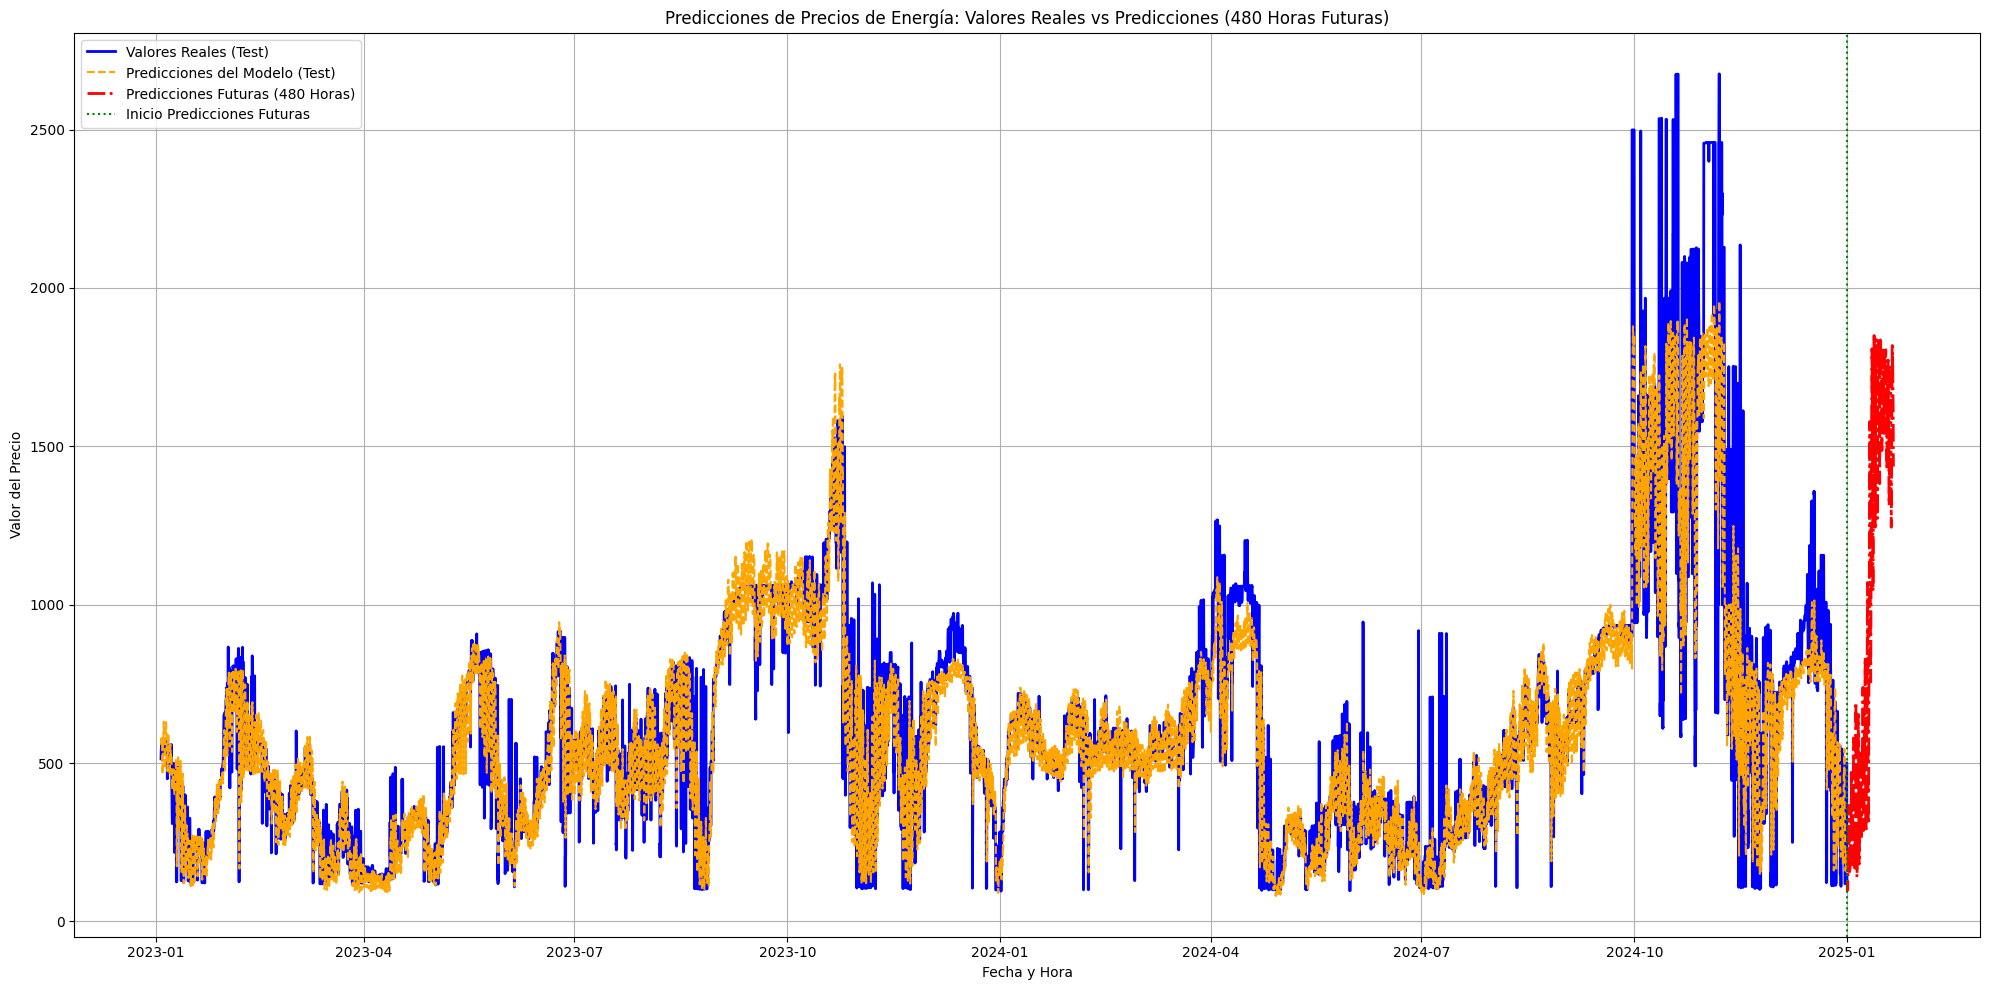


--- NOTA IMPORTANTE SOBRE LA PRECISIÓN DE PREDICCIONES A LARGO PLAZO ---
La precisión de las predicciones a 20 días puede ser baja debido a:
1. **Propagación del Error:** Los pequeños errores se acumulan en cada paso iterativo.
2. **Variables Exógenas:** Se asumió que 'CONTRATOS DE ENERGIA', 'GENERACION (KW)', y 'CONSUMO_COMBUSTIBLE_MBTU' (y sus derivados) permanecen constantes en sus últimos valores conocidos. Para predicciones precisas a largo plazo, ¡necesitarías pronósticos de estas variables también!
3. **Eventos No Modelados:** El modelo no puede predecir eventos futuros inesperados (cambios económicos, eventos climáticos extremos, fallas de infraestructura, etc.).

--- NOTA IMPORTANTE SOBRE LA PRECISIÓN DE PREDICCIONES A LARGO PLAZO ---
La precisión de las predicciones a 20 días puede ser baja debido a:
1. **Propagación del Error:** Los pequeños errores se acumulan en cada paso iterativo.
2. **Variables Exógenas:** Se asumió que 'CONTRATOS DE ENERGIA', 'GENERACION (KW)', y 'CON

In [ ]:

# -------------------------------------------------
# 14. Graficar los Resultados: Datos Reales (Test), Predicciones (Test) y Predicciones Futuras
# -------------------------------------------------

# Obtener los Datetime correspondientes al conjunto de prueba
# Esto asume que `X_train`, `X_test`, `time_steps`, y `df` están disponibles
start_datetime_test = df['Datetime'].iloc[len(X_train) + time_steps]
test_datetimes = pd.to_datetime([start_datetime_test + pd.Timedelta(hours=i) for i in range(len(y_test_descaled))])

# 1. Serie de valores reales del conjunto de prueba
actual_values_test_series = pd.Series(y_test_descaled.flatten(), index=test_datetimes)

# 2. Serie de predicciones del conjunto de prueba
# `predictions_descaled` debe ser el resultado de `model.predict(X_test)` desescalado
predictions_test_series = pd.Series(predictions_descaled.flatten(), index=test_datetimes)

# 3. Serie de predicciones futuras
# --- LÍNEA CORREGIDA AQUÍ ---
future_predictions_series = pd.Series(np.array(future_predictions_descaled).flatten(), index=future_datetimes)
# --- FIN DE LA LÍNEA CORREGIDA ---

plt.figure(figsize=(20, 10)) # Aumenta el tamaño para ver mejor los 20 días

# Graficar los Valores Reales del conjunto de prueba (un color)
plt.plot(actual_values_test_series.index, actual_values_test_series.values,
         label='Valores Reales (Test)', color='blue', linewidth=2)

# Graficar las Predicciones del conjunto de prueba (otro color)
plt.plot(predictions_test_series.index, predictions_test_series.values,
         label='Predicciones del Modelo (Test)', color='orange', linestyle='--', linewidth=1.5)

# Graficar las Predicciones Futuras (un tercer color o un estilo distinto)
plt.plot(future_predictions_series.index, future_predictions_series.values,
         label=f'Predicciones Futuras ({n_future_steps} Horas)', color='red', linestyle='-.', linewidth=2)

# Línea vertical para marcar el punto donde terminan los datos reales de prueba y comienzan las predicciones futuras
if future_datetimes:
    plt.axvline(x=future_datetimes[0], color='green', linestyle=':', label='Inicio Predicciones Futuras', linewidth=1.5)

plt.title(f'Predicciones de Precios de Energía: Valores Reales vs Predicciones ({n_future_steps} Horas Futuras)')
plt.xlabel('Fecha y Hora')
plt.ylabel('Valor del Precio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- NOTA IMPORTANTE SOBRE LA PRECISIÓN DE PREDICCIONES A LARGO PLAZO ---")
print("La precisión de las predicciones a 20 días puede ser baja debido a:")
print("1. **Propagación del Error:** Los pequeños errores se acumulan en cada paso iterativo.")
print("2. **Variables Exógenas:** Se asumió que 'CONTRATOS DE ENERGIA', 'GENERACION (KW)', y 'CONSUMO_COMBUSTIBLE_MBTU' (y sus derivados) permanecen constantes en sus últimos valores conocidos. Para predicciones precisas a largo plazo, ¡necesitarías pronósticos de estas variables también!")
print("3. **Eventos No Modelados:** El modelo no puede predecir eventos futuros inesperados (cambios económicos, eventos climáticos extremos, fallas de infraestructura, etc.).")

print("\n--- NOTA IMPORTANTE SOBRE LA PRECISIÓN DE PREDICCIONES A LARGO PLAZO ---")
print("La precisión de las predicciones a 20 días puede ser baja debido a:")
print("1. **Propagación del Error:** Los pequeños errores se acumulan en cada paso iterativo.")
print("2. **Variables Exógenas:** Se asumió que 'CONTRATOS DE ENERGIA', 'GENERACION (KW)', y 'CONSUMO_COMBUSTIBLE_MBTU' (y sus derivados) permanecen constantes en sus últimos valores conocidos. Para predicciones precisas a largo plazo, ¡necesitarías pronósticos de estas variables también!")
print("3. **Eventos No Modelados:** El modelo no puede predecir eventos futuros inesperados (cambios económicos, eventos climáticos extremos, fallas de infraestructura, etc.).")

En esta sección del código se realiza la integración visual de tres trayectorias: los valores reales del conjunto de prueba, las predicciones del modelo sobre ese mismo segmento y, enlazado en el tiempo, el tramo de predicciones futuras; el objetivo es contrastar adecuación en el período observado y continuidad del pronóstico más allá del último dato real.

start_datetime_test = df['Datetime'].iloc[len(X_train) + time_steps] — Determina el primer sello temporal del segmento de prueba, desplazando por la longitud de entrenamiento más la ventana para alinear salidas con sus índices.
test_datetimes = pd.to_datetime([start_datetime_test + pd.Timedelta(hours=i) for i in range(len(y_test_descaled))]) — Genera el vector de marcas temporales para cada observación de prueba, avanzando hora a hora desde el punto de inicio.

actual_values_test_series = pd.Series(y_test_descaled.flatten(), index=test_datetimes) — Construye una serie temporal con los valores reales de prueba en escala original, indexada por su Datetime.
predictions_test_series = pd.Series(predictions_descaled.flatten(), index=test_datetimes) — Crea la serie homóloga de predicciones desescaladas sobre el mismo índice temporal, garantizando comparabilidad punto a punto.
future_predictions_series = pd.Series(np.array(future_predictions_descaled).flatten(), index=future_datetimes) — Materializa la serie de pronósticos futuros encadenados, indexada por las fechas prospectivas calculadas durante la proyección.

plt.figure(figsize=(20, 10)) — Abre una figura amplia para visualizar con claridad 20 días de horizonte.
plt.plot(actual_values_test_series.index, actual_values_test_series.values, label='Valores Reales (Test)', color='blue', linewidth=2) — Traza la trayectoria real del conjunto de prueba con estilo destacado.
plt.plot(predictions_test_series.index, predictions_test_series.values, label='Predicciones del Modelo (Test)', color='orange', linestyle='--', linewidth=1.5) — Superpone las predicciones sobre prueba con trazo discontinuo para facilitar la comparación.
plt.plot(future_predictions_series.index, future_predictions_series.values, label=f'Predicciones Futuras ({n_future_steps} Horas)', color='red', linestyle='-.', linewidth=2) — Añade la proyección futura, diferenciada por color y estilo para resaltar el tramo prospectivo.

if future_datetimes: plt.axvline(x=future_datetimes, color='green', linestyle=':', label='Inicio Predicciones Futuras', linewidth=1.5) — Inserta una línea vertical en el instante donde termina el dato observado y comienza el pronóstico, marcando la frontera entre validación histórica y extrapolación.
plt.title(f'Predicciones de Precios de Energía: Valores Reales vs Predicciones ({n_future_steps} Horas Futuras)') — Contextualiza el gráfico con el horizonte usado.
plt.xlabel('Fecha y Hora'); plt.ylabel('Valor del Precio') — Etiqueta ejes con semántica temporal y magnitud en escala original.
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show() — Activa leyenda, retícula y ajuste de márgenes, y renderiza la figura final.

print("\n--- NOTA IMPORTANTE SOBRE LA PRECISIÓN DE PREDICCIONES A LARGO PLAZO ---") — Introduce una advertencia explícita sobre limitaciones del horizonte extendido.
print("La precisión de las predicciones a 20 días puede ser baja debido a:") — Enuncia el alcance de la advertencia.
print("1. Propagación del Error: Los pequeños errores se acumulan en cada paso iterativo.") — Señala el efecto acumulativo típico de los esquemas autoregresivos.
print("2. Variables Exógenas: Se asumió que 'CONTRATOS DE ENERGIA', 'GENERACION (KW)', y 'CONSUMO_COMBUSTIBLE_MBTU' (y sus derivados) permanecen constantes en sus últimos valores conocidos. Para predicciones precisas a largo plazo, ¡necesitarías pronósticos de estas variables también!") — Declara la hipótesis de covariables congeladas y su impacto en el realismo del pronóstico.
print("3. Eventos No Modelados: El modelo no puede predecir eventos futuros inesperados (cambios económicos, eventos climáticos extremos, fallas de infraestructura, etc.).") — Reconoce choques exógenos no parametrizados que degradan precisión.
print("\n--- NOTA IMPORTANTE SOBRE LA PRECISIÓN DE PREDICCIONES A LARGO PLAZO ---"); print("La precisión de las predicciones a 20 días puede ser baja debido a:"); print("1. Propagación del Error: Los pequeños errores se acumulan en cada paso iterativo."); print("2. Variables Exógenas: Se asumió que 'CONTRATOS DE ENERGIA', 'GENERACION (KW)', y 'CONSUMO_COMBUSTIBLE_MBTU' (y sus derivados) permanecen constantes en sus últimos valores conocidos. Para predicciones precisas a largo plazo, ¡necesitarías pronósticos de estas variables también!"); print("3. Eventos No Modelados: El modelo no puede predecir eventos futuros inesperados (cambios económicos, eventos climáticos extremos, fallas de infraestructura, etc.).") — Reitera el aviso para reforzar la lectura, subrayando las tres fuentes principales de incertidumbre.

El resultado es una visual integradora que permite juzgar fidelidad histórica y continuidad del pronóstico, junto con una aclaración metodológica sobre los supuestos y las fuentes de error que, a horizontes largos, condicionan la precisión esperada.